<a href="https://www.kaggle.com/code/anirbansaha96/asl-vgg19bn-pytorch?scriptVersionId=91782113" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import os
import numpy as np
from PIL import Image
import random
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import torch
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

In [2]:
train_subdir = os.listdir('../input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/')
train_subdir.sort()

In [3]:
trainfolder = '../input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/'
df_list = []
for subdir in train_subdir:
    files = os.listdir(trainfolder + subdir)
    df_list.extend([(trainfolder + subdir + '/' + filename, subdir) for filename in files])

In [4]:

randomlist = random.sample(range(1, len(df_list)), 5)
print([df_list[index] for index in randomlist])

[('../input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/S/S2065.jpg', 'S'), ('../input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/G/G1224.jpg', 'G'), ('../input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/Q/Q1416.jpg', 'Q'), ('../input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/A/A1932.jpg', 'A'), ('../input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/F/F1390.jpg', 'F')]


In [5]:

fullDF = pd.DataFrame(df_list, columns =['Path', 'Label'])

In [6]:
fullDF

,Path,Label
0,../input/asl-alphabet/asl_alphabet_train/asl_a...,A
1,../input/asl-alphabet/asl_alphabet_train/asl_a...,A
2,../input/asl-alphabet/asl_alphabet_train/asl_a...,A
3,../input/asl-alphabet/asl_alphabet_train/asl_a...,A
4,../input/asl-alphabet/asl_alphabet_train/asl_a...,A
...,...,...
86995,../input/asl-alphabet/asl_alphabet_train/asl_a...,space
86996,../input/asl-alphabet/asl_alphabet_train/asl_a...,space
86997,../input/asl-alphabet/asl_alphabet_train/asl_a...,space
86998,../input/asl-alphabet/asl_alphabet_train/asl_a...,space


In [7]:

# Encode the label
le = LabelEncoder()
label_encoded = le.fit_transform(fullDF['Label'])
fullDF['Label'] = label_encoded


# Taking the class name
label_names = le.classes_
print(label_names)

['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R'
 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z' 'del' 'nothing' 'space']


In [8]:
fullDF.iloc[0, 0]

'../input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/A/A1946.jpg'

In [9]:

X_train, X_rest, y_train, y_rest = train_test_split(fullDF['Path'], fullDF['Label'],
                                                    stratify=fullDF['Label'], 
                                                    test_size=0.2)

X_valid, X_test, y_valid, y_test = train_test_split(X_rest, y_rest,
                                                    stratify=y_rest, 
                                                    test_size=0.5)

In [10]:
print("Train Size", len(X_train))
print("Valid Size", len(X_valid))
print("Test Size",  len(X_test))

Train Size 69600
Valid Size 8700
Test Size 8700


In [11]:
X_train.head()

38868    ../input/asl-alphabet/asl_alphabet_train/asl_a...
23105    ../input/asl-alphabet/asl_alphabet_train/asl_a...
66898    ../input/asl-alphabet/asl_alphabet_train/asl_a...
2858     ../input/asl-alphabet/asl_alphabet_train/asl_a...
75879    ../input/asl-alphabet/asl_alphabet_train/asl_a...
Name: Path, dtype: object

In [12]:
y_train.head()

38868    12
23105     7
66898    22
2858      0
75879    25
Name: Label, dtype: int64

In [13]:

transform = {
    'train' : transforms.Compose([transforms.Resize(256),
                                  transforms.RandomResizedCrop(224),
                                  transforms.RandomHorizontalFlip(),
                                  transforms.RandomRotation(10),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                       std=[0.229, 0.224, 0.225])]),
    
    'valid' : transforms.Compose([transforms.Resize(256),
                                  transforms.CenterCrop(224),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                       std=[0.229, 0.224, 0.225])]),
    
    'test' : transforms.Compose([transforms.Resize(256),
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                      std=[0.229, 0.224, 0.225])])
}

In [14]:


class ASLDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        # Return the observation based on an index. Ex. dataset[0] will return the first element from the dataset, in this case the image and the label.
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name = self.X.iloc[idx]
        image = Image.open(img_name)
        label = self.y.iloc[idx]
        
        if self.transform:
            image = self.transform(image)
    
        return (image, label)

In [15]:
image_datasets = {
    'train' : ASLDataset(X_train, y_train, transform['train']),
    'valid' : ASLDataset(X_valid, y_valid, transform['valid']),
    'test'  : ASLDataset(X_test,  y_test,  transform['test'] )
                 }

In [16]:

num_workers = 0
batch_size = 20

data_loaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                              shuffle=True, num_workers=num_workers)
               for x in ['train', 'valid', 'test']}

In [17]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid', 'test']}

print('Number of records of training dataset: {}'.format(dataset_sizes['train']))
print('Number of records of validation dataset: {}'.format(dataset_sizes['valid']))
print('Number of records of test dataset: {}'.format(dataset_sizes['test']))

Number of records of training dataset: 69600
Number of records of validation dataset: 8700
Number of records of test dataset: 8700


In [18]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        try:
            for batch_idx, (data, target) in enumerate(loaders['train']):
                # move to GPU
                if use_cuda:
                    data = data.cuda()
                    target = target.cuda()
                ## find the loss and update the model parameters accordingly
                ## record the average training loss, using something like
                ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()*data.size(0)
        except Exception as e:
            print(e)
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            loss = criterion(output, target)
            valid_loss += loss.item()*data.size(0)
        
        train_loss = train_loss/len(loaders['train'].dataset)
        valid_loss = valid_loss/len(loaders['valid'].dataset)
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss   
    # return trained model
    return model

def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [19]:


## TODO: Specify model architecture 
model_transfer = models.vgg19_bn(pretrained=True)
# Freeze training for all "features" layers
for param in model_transfer.features.parameters():
    param.requires_grad = False 
model_transfer.classifier[6] = nn.Linear(in_features=model_transfer.classifier[6].in_features, out_features=len(label_names), bias=True)

use_cuda = torch.cuda.is_available()

if use_cuda:
    model_transfer = model_transfer.cuda()

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [20]:


criterion_transfer = nn.CrossEntropyLoss()

optimizer_transfer = optim.SGD(model_transfer.classifier.parameters(), lr=0.001)

In [21]:
model_transfer = train(10, data_loaders, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 2.734967 	Validation Loss: 1.868872
Validation loss decreased (inf --> 1.868872).  Saving model ...
Epoch: 2 	Training Loss: 2.042659 	Validation Loss: 1.315625
Validation loss decreased (1.868872 --> 1.315625).  Saving model ...
Epoch: 3 	Training Loss: 1.806259 	Validation Loss: 1.052132
Validation loss decreased (1.315625 --> 1.052132).  Saving model ...
Epoch: 4 	Training Loss: 1.671169 	Validation Loss: 0.847980
Validation loss decreased (1.052132 --> 0.847980).  Saving model ...
Epoch: 5 	Training Loss: 1.573872 	Validation Loss: 0.770503
Validation loss decreased (0.847980 --> 0.770503).  Saving model ...
Epoch: 6 	Training Loss: 1.499222 	Validation Loss: 0.675552
Validation loss decreased (0.770503 --> 0.675552).  Saving model ...
Epoch: 7 	Training Loss: 1.449762 	Validation Loss: 0.599876
Validation loss decreased (0.675552 --> 0.599876).  Saving model ...
Epoch: 8 	Training Loss: 1.398534 	Validation Loss: 0.546174
Validation loss decreased (0.59987

<All keys matched successfully>

In [25]:
test(data_loaders, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.490681


Test Accuracy: 85% (7435/8700)


In [32]:
import matplotlib.pyplot as plt
def predict_(img_path):
    # load the image and return the predicted breed
    img = Image.open(img_path)
    img_tensor = transform['test'](img).to('cuda').unsqueeze(0)
    model_transfer.eval()
    output = model_transfer(img_tensor)
    _, index = torch.max(output, 1)
    index = index.cpu().tolist()
    plt.imshow(img)
    plt.show()
    return le.inverse_transform(index)[0]

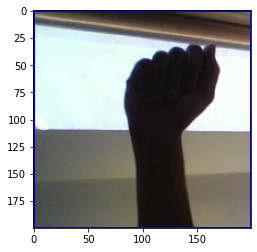

That is correct - True Label = A and Prediction : A


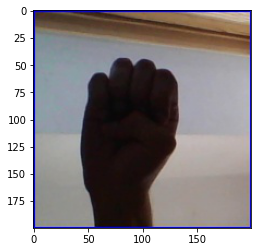

That is correct - True Label = E and Prediction : E


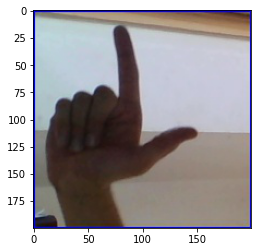

That is correct - True Label = L and Prediction : L


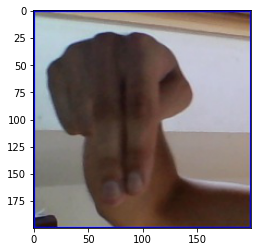

That is correct - True Label = N and Prediction : N


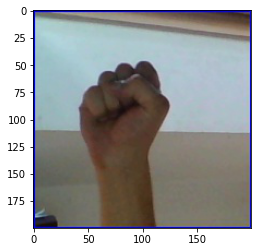

That is Wrong - True Label = S and Prediction : E. However, E looks like : 


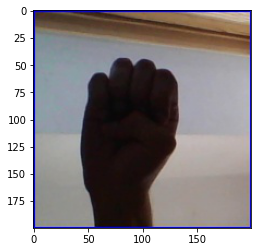

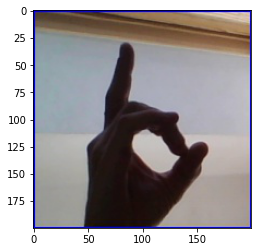

That is correct - True Label = D and Prediction : D


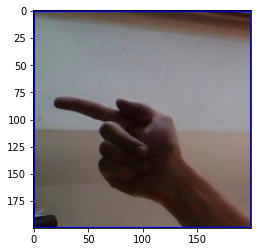

That is correct - True Label = G and Prediction : G


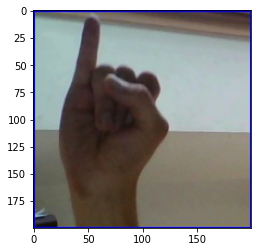

That is correct - True Label = I and Prediction : I


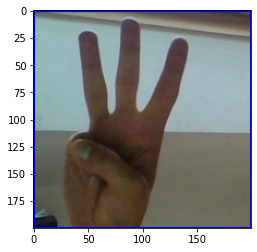

That is correct - True Label = W and Prediction : W


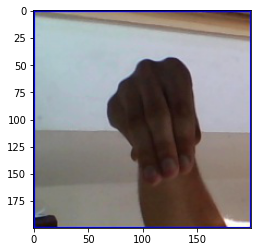

That is correct - True Label = M and Prediction : M


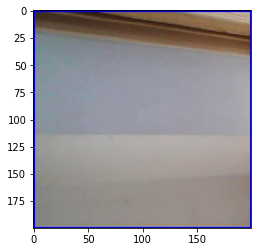

That is correct - True Label = nothing and Prediction : nothing


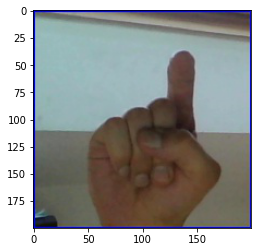

That is correct - True Label = X and Prediction : X


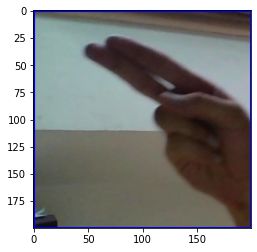

That is correct - True Label = H and Prediction : H


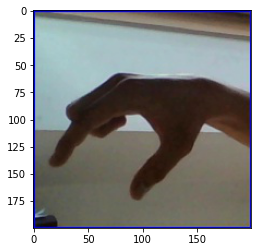

That is correct - True Label = Q and Prediction : Q


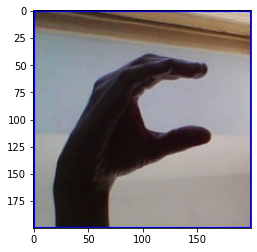

That is correct - True Label = C and Prediction : C


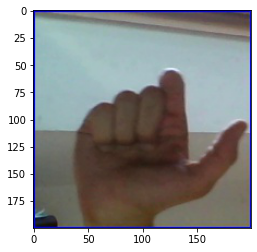

That is correct - True Label = T and Prediction : T


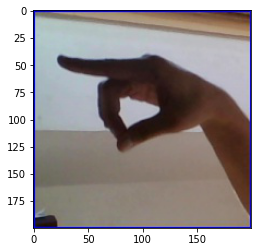

That is Wrong - True Label = P and Prediction : C. However, C looks like : 


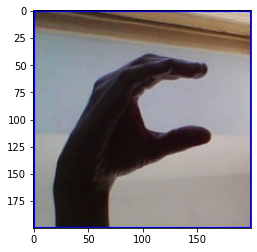

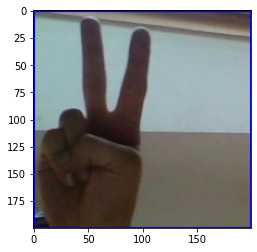

That is correct - True Label = V and Prediction : V


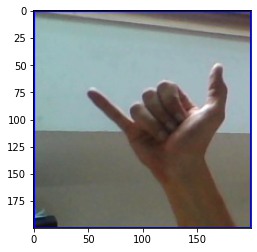

That is correct - True Label = Y and Prediction : Y


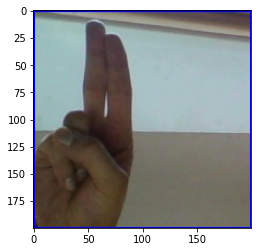

That is correct - True Label = U and Prediction : U


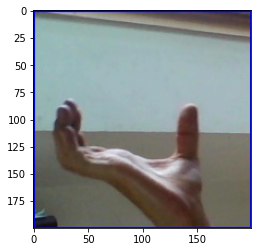

That is correct - True Label = space and Prediction : space


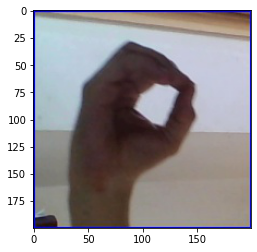

That is correct - True Label = O and Prediction : O


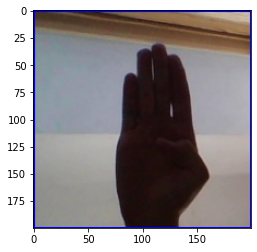

That is correct - True Label = B and Prediction : B


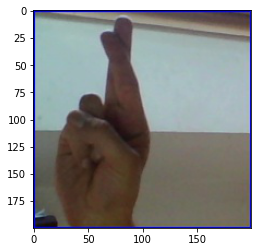

That is correct - True Label = R and Prediction : R


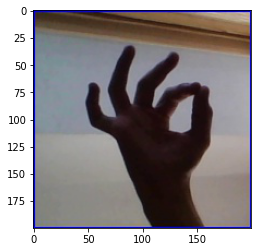

That is correct - True Label = F and Prediction : F


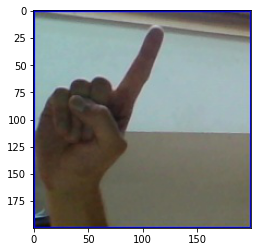

That is Wrong - True Label = Z and Prediction : X. However, X looks like : 


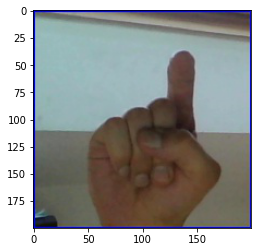

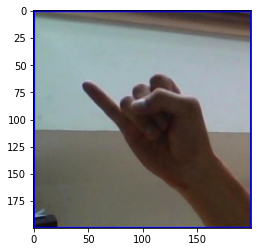

That is correct - True Label = J and Prediction : J


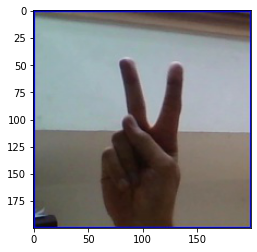

That is correct - True Label = K and Prediction : K


In [40]:
for file in os.listdir('../input/asl-alphabet/asl_alphabet_test/asl_alphabet_test'):
    path = '../input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/'+file
    prediction = predict_(path)
    true_label = file.split('_')[0]
    if prediction == true_label:
        print(f'That is correct - True Label = {true_label} and Prediction : {prediction}')
    else:
        print(f'That is Wrong - True Label = {true_label} and Prediction : {prediction}. However, {prediction} looks like : ')
        img_path = '../input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/'+prediction+'_test.jpg'
        img = Image.open(img_path)
        plt.imshow(img)
        plt.show()
        